In [ ]:
%%writefile l5_code.py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.metrics import r2_score, mean_squared_error
import pytest
import os


# функция генерации датасетов
def generate_loan_dataset(sample_size=50, anomaly_ratio=0):
    # инициализируем random
    rng = np.random.default_rng()
    # генерируем значения фич age, incom, cred_rating, employment
    age = rng.integers(low=18, high=65, size=sample_size)
    income = np.round(80000 * rng.lognormal(mean=0, sigma=0.3, size=sample_size), 2)
    credit_rating = rng.integers(low=100, high=999, size=sample_size)
    employment = np.round(40 * rng.random(size=sample_size), 1)
    # генерируем шум
    #noises = rng.random(size=sample_size) * 1000000
    noises = 0

    # рассчитываем целевую переменную - кредитный лимит
    credit_limit = np.round(
        (age * 1000 + income * 7 + credit_rating * 100 + employment * 2000 + noises), 0
    )
    # print(target)

    # считаем количесвто аномалий, которые будем генерировать
    anomaly_numbers = int(anomaly_ratio * sample_size)
    # генерируем отдельно высокие и низкие аномалии (поровну)
    a_max = rng.random(int(anomaly_numbers/2))*max(credit_limit) + max(credit_limit)
    a_min = rng.random(int(anomaly_numbers/2))*min(credit_limit)
    anomaly = np.concatenate((a_max, a_min))


    # перемешиваем аномалии внутри (высокие с низкими)
    rng.shuffle(anomaly)
    # создаем массив индексов, в значения которых будем подставлять аномалии
    ind = rng.integers(low=0, high=sample_size, size=anomaly_numbers)
    credit_limit[ind] = np.round((anomaly), 0)

    # делаем датафрейм из массивов фич и таргетов
    df = pd.DataFrame(
        {
            "age": age,
            "income": income,
            "credit_rating": credit_rating,
            "employment": employment,
            "credit_limit": credit_limit,
        }
    )
    return df



# тренировка модели
def train_model(ds):
    # отправляем в X - данные с фичами, а в y - таргеты
    X = ds[ds.columns[:-1]]
    y = ds[ds.columns[-1:]]

    # создаем модель линейной регрессии и  тренируем ее
    model = LinearRegression()
    model.fit(X, y)

    return model


# тестирование модели
def test_model(model, ds):
    # отправляем в X - данные с фичами, а в y - таргеты
    X = ds[ds.columns[:-1]]
    y = ds[ds.columns[-1:]]

    # предсказываем данные
    y_pred = model.predict(X)

    # расчет метрик
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return {"MSE": mse, "R2": r2}


def test_datasets():
    num_ds = 4
    model = joblib.load(model.joblib)
    ds = {}
    for i in range(num_ds):
        ds[i] = pd.read_csv(f'data/ds-{i}.csv')
        X = ds[i][ds[i].columns[:-1]]
        y = ds[i][ds[i].columns[-1:]]

        # предсказываем данные
        y_pred = model.predict(X)

        # расчет метрики r2
        r2 = r2_score(y, y_pred)
        assert r2 > 0.95, f"Failed model test! R2 = {r2}. Dataset is: ds-{i}.csv"



if __name__ == "__main__":
    os.makedirs("data", exist_ok=True)
    # всего будет 4 датасета (3 норм, 1 с шумами)
    num_dataset = 4
    ds = {}
    # генерируем датасеты без аномалий
    for i in range(1, num_dataset):
        ds[i] = generate_loan_dataset(sample_size=1000, anomaly_ratio=0.00)
        # сохраняем датасет
        ds[i].to_csv(f"data/ds-{i}.csv", index=False)

    # обучаем модель на одном из качественных датасетов и сохраняем ее
    model = train_model(ds[1])
    joblib.dump(model, "data/model.joblib")

    # генерируем зашумленный датасет и сохраняем его в файл
    ds[num_dataset] = generate_loan_dataset(sample_size=1000, anomaly_ratio=0.02)
    ds[num_dataset].to_csv(f"data/ds-{num_dataset}.csv", index=False)

    # смотрим показатели модели на 3 качественных и одном зашумленном датасете
    for i in range(1, num_dataset+1):
        print(test_model(model, ds[i]))

Overwriting l5_code.py


In [ ]:
# запускаем отработку кода основной части программы, в которой формируем датасеты и обучаем модель
!python3 l5_code.py

{'MSE': 0.08394827330393388, 'R2': 0.9999999999974426}
{'MSE': 0.08265008703597465, 'R2': 0.9999999999976241}
{'MSE': 0.08743119211535444, 'R2': 0.9999999999972704}
{'MSE': 41337784793.54076, 'R2': 0.462101935865476}


In [ ]:
%%writefile l5_test.py

import pandas as pd
import joblib
from sklearn.metrics import r2_score


def test_datasets():
    num_ds = 4

    model = joblib.load("data/model.joblib")
    ds = {}
    for i in range(1, num_ds+1):
        ds[i] = pd.read_csv(f'data/ds-{i}.csv')
        X = ds[i][ds[i].columns[:-1]]
        y = ds[i][ds[i].columns[-1:]]

        # предсказываем данные
        y_pred = model.predict(X)

        # расчет метрики r2
        r2 = r2_score(y, y_pred)
        assert r2 > 0.95, f"The ds-{i}.csv dataset is bad!! R2 = {r2}."

Overwriting l5_test.py


In [ ]:
!pytest l5_test.py

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content
plugins: anyio-3.7.1
collected 1 item                                                                                   

l5_test.py F                                                                                 [100%]

============================================= FAILURES =============================================
__________________________________________ test_datasets ___________________________________________

    def test_datasets():
        num_ds = 4
    
        model = joblib.load("data/model.joblib")
        ds = {}
        for i in range(1, num_ds+1):
            ds[i] = pd.read_csv(f'data/ds-{i}.csv')
            X = ds[i][ds[i].columns[:-1]]
            y = ds[i][ds[i].columns[-1:]]
    
            # предсказываем данные
            y_pred = model.predict(X)
    
            # расчет мет

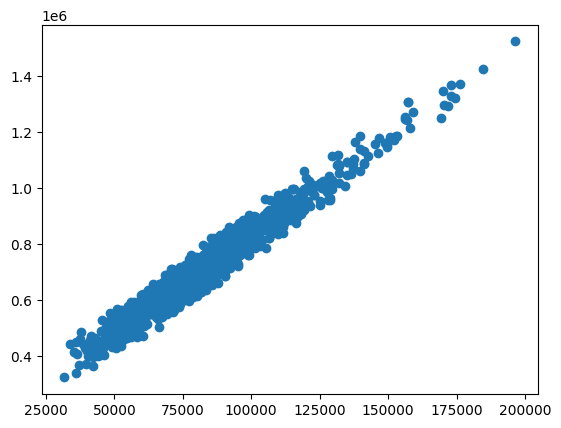

In [ ]:
# пример качественного датасета
ds = pd.read_csv('data/ds-1.csv')
plt.scatter(ds['income'], ds['credit_limit'])
plt.show()

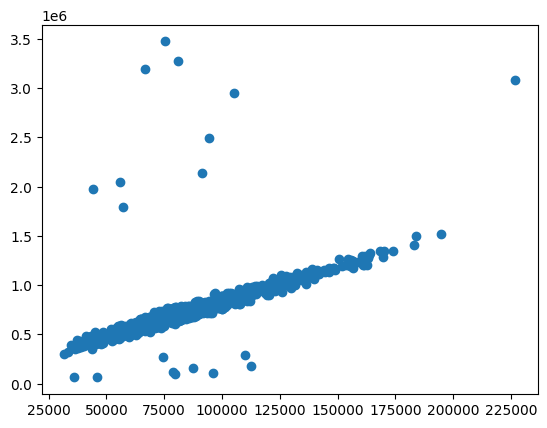

In [ ]:
# пример датасета с сильными выбросами
ds = pd.read_csv('data/ds-4.csv')
plt.scatter(ds['income'], ds['credit_limit'])
plt.show()